# loading EDAX data via hyperspy and rosettasciio


This notebook loads up a sample EDAX file (`.spd`) manually via `rosettasciio` and then using `hyperspy`, does some data inspection and then creates spectra by summing over the spatial indices of the x-ray maps. 

Helpful: 

* https://hyperspy.org/rosettasciio/supported_formats/edax.html#edax-format


### Data inspection

In [1]:
from rsciio import edax
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import hyperspy.api as hs 

datadir = os.environ.get("EXTRACTACOMPDATADIR")

def _get_files(basename: str) -> list[str]: 
    subdir = os.path.join(datadir, basename, "Proprietary EDAX Files")    
    fispd = os.path.join(subdir, f"{basename}.spd")
    fiipr = os.path.join(subdir, f"{basename}.ipr")
    return fispd, fiipr 
    
def load_edax_spd(basename: str):  
    print(f"loading {fispd}")
    fispd, fiipr = _get_files(basename)     
    ds = edax.file_reader(fispd, ipr_fname=fiipr)    
    return ds  

def load_via_hyperspy(basename:str):
    fispd, fiipr = _get_files(basename)     
    ds = edax.file_reader(fispd, ipr_fname=fiipr)  
    return hs.load(fispd, ipr_fname=fiipr)    

def find_data_start(msa_path: str) -> int: 
    idx = 0
    with open(msa_path,'r') as fh: 
        while True:
            idx += 1
            msa_data = fh.readline()            
            if "Spectral Data Starts Here" in msa_data:
                return idx 
            elif idx > 100: 
                raise RuntimeError("Could not indentify starting row for msa data")  

def load_msa(msa_path: str) -> pd.DataFrame: 
    # Note: rosetasciio supports "Y" and "XY" formats, this loader assumes "XY". 
    # TODO: handle "Y", also save the metadata.
    idx = find_data_start(msa_path)    
    # engine='python' to avoid warning using skipfooter
    df = pd.read_csv(msa_path, skiprows=idx, header=None, names=["x", "intensity"], skipfooter=1, engine='python')
    return df

## Direct load via RosettaSciIO

In [2]:
ds = load_edax_spd('C-12')

loading /home/chavlin/hdd/data/extractacomp_/TorresSamples/C-12/Proprietary EDAX Files/C-12.spd


In [3]:
type(ds[0]), ds[0].keys()

(dict, dict_keys(['data', 'axes', 'metadata', 'original_metadata']))

The raw data is loaded as a `numpy.memmap` object! This is excellent. 

In [4]:
type(ds[0]['data'])

numpy.memmap

In [5]:
ds[0]['data'].shape

(800, 1024, 3000)

In [6]:
ds[0]['axes']

[{'size': 800,
  'index_in_array': 0,
  'name': 'y',
  'scale': np.float32(1.5876777),
  'offset': 0,
  'units': 'µm',
  'navigate': True},
 {'size': 1024,
  'index_in_array': 1,
  'name': 'x',
  'scale': np.float32(1.6013774),
  'offset': 0,
  'units': 'µm',
  'navigate': True},
 {'size': 3000,
  'index_in_array': 2,
  'name': 'Energy',
  'scale': np.float64(0.005),
  'offset': np.float32(0.0),
  'units': 'keV',
  'navigate': False}]

let's plot an image... extract data around the peak energy, sum it and plot:

In [7]:
index_start=345 
index_end=355
subsample = ds[0]['data'][:,:,index_start:index_end]

energy_scale = ds[0]['axes'][2]['scale']
energy_range = np.array([energy_scale * index_start, energy_scale*index_end])
energy_range, ds[0]['axes'][2]['units'] # Si? maybe? 

(array([1.725, 1.775]), 'keV')

In [8]:
subsample_plain = np.asarray(subsample)

In [9]:
im = subsample_plain.sum(axis=-1)

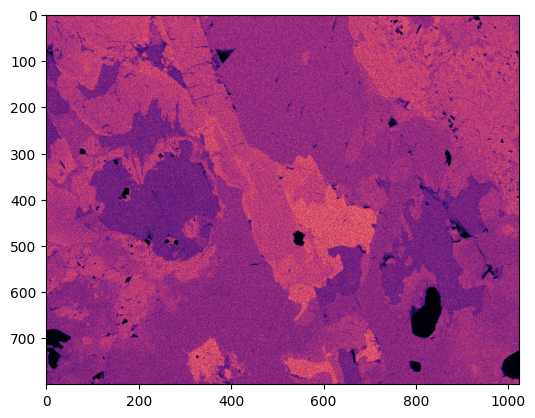

In [10]:
plt.imshow(im, cmap='magma')

In [11]:
ds[0]['metadata']

{'General': {'original_filename': 'C-12.spd', 'title': 'EDS Spectrum Image'},
 'Signal': {'signal_type': 'EDS_SEM'},
 'Acquisition_instrument': {'SEM': {'Detector': {'EDS': {'azimuth_angle': np.float32(0.0),
     'elevation_angle': np.float32(33.5),
     'energy_resolution_MnKa': np.float32(125.19505),
     'live_time': np.float32(3276.8)}},
   'beam_energy': np.float32(15.0),
   'Stage': {'tilt_alpha': np.float32(0.0)}}},
 'Sample': {'elements': ['Al', 'Ca', 'Fe', 'K', 'Mg', 'Na', 'O', 'Si']}}

## Manual summation over spatial indices 

Since the data are loaded as `memmap` array, can easily sum without pulling the full file into memory by iterating over chunks of the energy axis. 

In [12]:
chunksize = 500 
n_chunks = int(np.ceil(ds[0]['axes'][2]['size'] / chunksize))
n_chunks

6

In [13]:
maxindex = ds[0]['axes'][2]['size']
channel_sums = np.zeros((maxindex,))

In [14]:
%%time
for ichunk in range(n_chunks):
    channel_start = ichunk * chunksize
    channel_end = channel_start + chunksize 
    if channel_end > maxindex:
        channel_end = maxindex 
    print(f"integrating over channel range ({channel_start}, {channel_end})")
    subsample = np.array(ds[0]['data'][:,:,channel_start: channel_end])
    sumvalues = subsample.sum(axis=0).sum(axis=0)
    channel_sums[channel_start:channel_end] = sumvalues 

integrating over channel range (0, 500)
integrating over channel range (500, 1000)
integrating over channel range (1000, 1500)
integrating over channel range (1500, 2000)
integrating over channel range (2000, 2500)
integrating over channel range (2500, 3000)
CPU times: user 1.59 s, sys: 148 ms, total: 1.74 s
Wall time: 1.74 s


(0.0, 8.0)

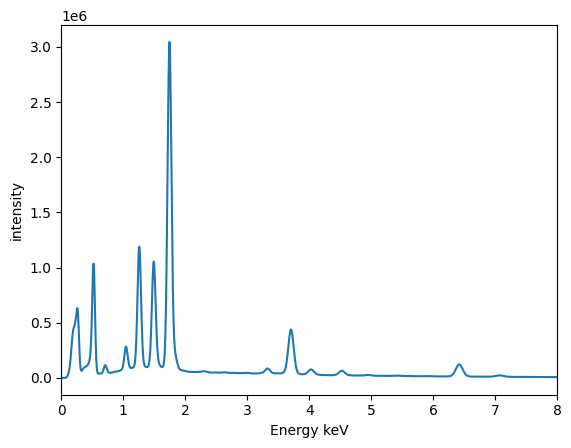

In [15]:
x = np.arange(ds[0]['axes'][2]['size']) * ds[0]['axes'][2]['scale']
plt.plot(x, channel_sums)
plt.xlabel(ds[0]['axes'][2]['name'] + " " + ds[0]['axes'][2]['units'])
plt.ylabel("intensity")
plt.xlim([0, 8])

In [16]:
max_location = np.where(channel_sums == channel_sums.max())[0]
max_location, energy_scale * max_location

(array([349]), array([1.745]))

## Summation with hyperspy

In [17]:
from hyperspy.signals import Signal1D
s = Signal1D(ds[0]['data'], axes=ds[0]['axes'], metadata=ds[0]['metadata'], original_metadata=ds[0]['original_metadata'])

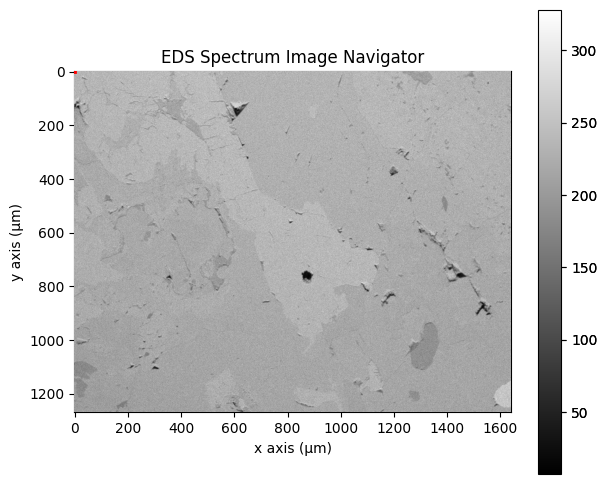

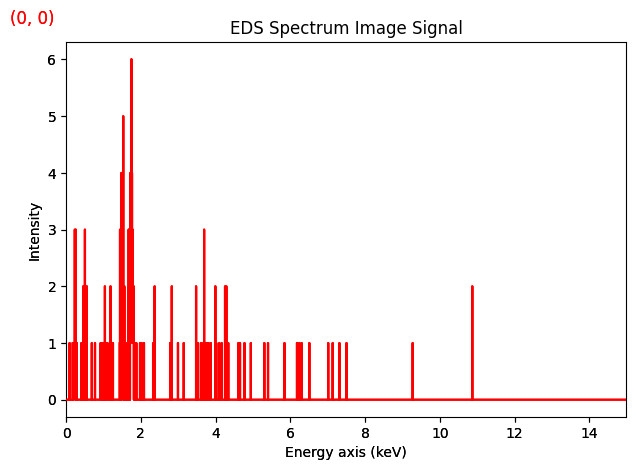

In [18]:
s.plot()

That spectrum is for a single pixel (0, 0)... for the whole sample:

(0.0, 8.0)

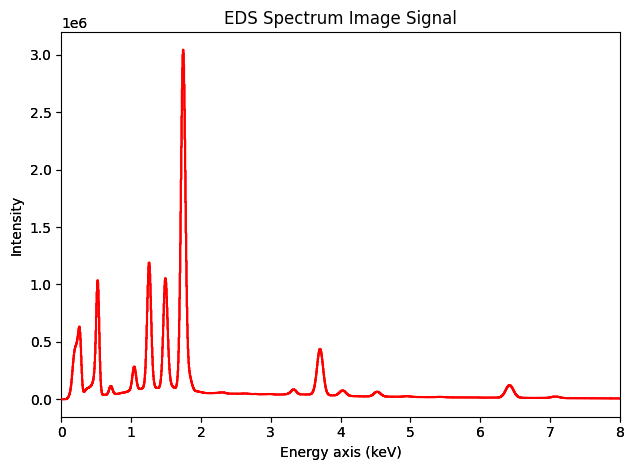

In [19]:
s1 = s.sum()
s1.plot()
plt.xlim([0, 8])

### check that it matches the manual sum

(it does)

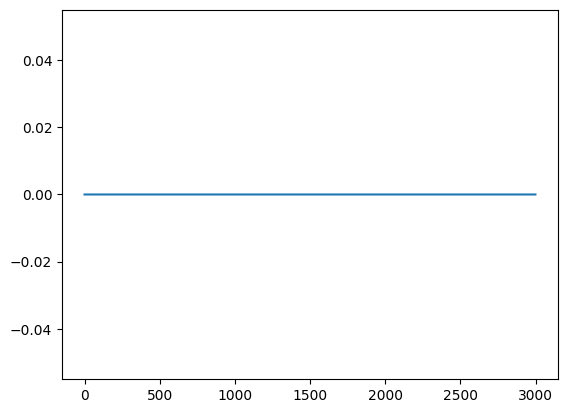

In [20]:
plt.plot(channel_sums - s1.data)

In [21]:
np.max(np.abs(channel_sums - s1.data))

np.float64(0.0)

## Loading with hyperspy 


In [2]:
ds = load_via_hyperspy('C-12')
ds

/Users/chavlin/src/extractacomp_/extractacomp_exploration/.venv/lib/python3.13/site-packages/hyperspy/misc/_utils.py:1590: VisibleDeprecationWarning: Importing `LazyComplexSignal1D` from `hyperspy._signals.complex_signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warnings.warn(
/Users/chavlin/src/extractacomp_/extractacomp_exploration/.venv/lib/python3.13/site-packages/hyperspy/misc/_utils.py:1590: VisibleDeprecationWarning: Importing `LazySignal1D` from `hyperspy._signals.signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warnings.warn(
/Users/chavlin/src/extractacomp_/extractacomp_exploration/.venv/lib/python3.13/site-packages/hyperspy/misc/_utils.py:1590: VisibleDeprecationWarning: Importing `LazySignal1D` from `hyperspy._signals.signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warn

<EDSSEMSpectrum, title: EDS Spectrum Image, dimensions: (1024, 800|3000)>

In [10]:
type(ds)

exspy.signals.eds_sem.EDSSEMSpectrum

The `data` attribute contains the raw `memmap` array:

In [6]:
type(ds.data), ds.data.shape

(numpy.memmap, (800, 1024, 3000))

can utilize `as_lazy` to get a lazy dask array:

In [7]:
lazy_signal = ds.as_lazy()

In [8]:
lazy_signal

<LazyEDSSEMSpectrum, title: EDS Spectrum Image, dimensions: (1024, 800|3000)>

individual chunks are composed of pixel ranges (navigation axes) that span the entire signal axis (e.g., in the above default case: 128,200 pixel chunk size by 3000 in the signal axis). 

Unfortunately for edax files, seems that each dask worker requires the full `memmap` array, which ends up allocating the full array size to each worker.... 

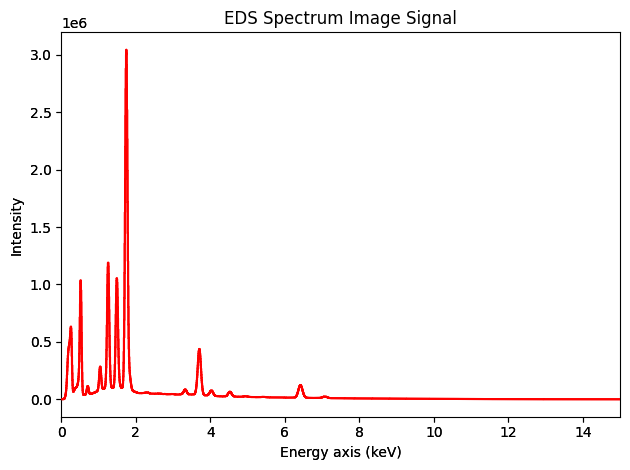

In [12]:
ds.sum().plot()

## MSA files

### exporting, reloading with hyperspy 

saving off via hyperspy, can just do a `.save()` (which usesh rosettasciio on the back)

In [22]:
s1.save('hs_msa.msa',format='XY')

In [23]:
df_rt = load_msa('hs_msa.msa')
df_rt

,x,intensity
0,0.000,0.0
1,0.005,0.0
2,0.010,0.0
3,0.015,0.0
4,0.020,0.0
...,...,...
2995,14.975,9.0
2996,14.980,3.0
2997,14.985,6.0
2998,14.990,8.0


(0.0, 8.0)

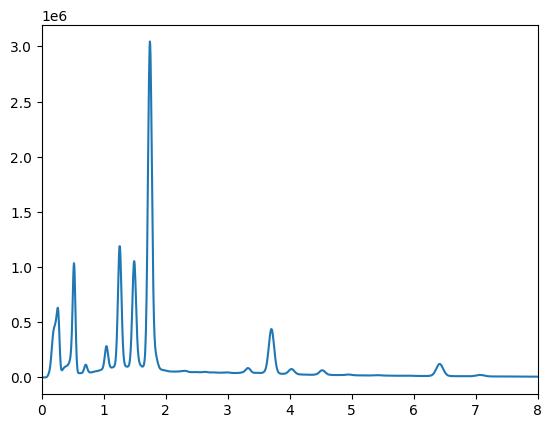

In [24]:
plt.plot(df_rt.x, df_rt.intensity)
plt.xlim([0, 8])

### loading the standard

This msa is a standard that Craig ran and gave us the MSA file for

(0.0, 8000.0)

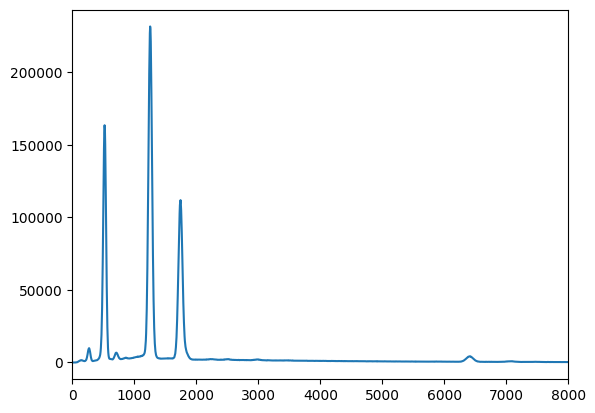

In [25]:
msa_path = os.path.join(datadir, "C-12", "Spectrum_1.msa")
df_standard = load_msa(msa_path)
plt.plot(df_standard.x, df_standard.intensity)
plt.xlim([0, 8*1000])

### cleanup

In [26]:
import os 
os.remove('hs_msa.msa')